In [ ]:
#%matplotlib inline  
#%load_ext autoreload
#%autoreload 2
#%cd ../src

from torchvision import models
from torch.nn.modules import Softmax
from matplotlib import pyplot as plt
import numpy as np
import torch
from plot_utils import show

import midnite
from midnite.visualization.base import *

In [2]:
alexnet = models.alexnet(pretrained=True)

# 1. Channel-wise regularization/transformation comparisons
Here we will look at the effect of different regularizers.
## 1.1 No regularization

100%|██████████| 12/12 [00:15<00:00,  1.15s/it]


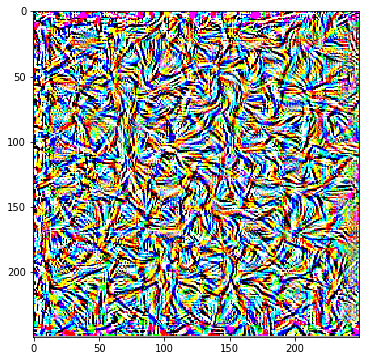

In [3]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
).visualize())

## 1.2 Weight decay (l1)
Less relevant parts of the image are set to zero.

100%|██████████| 12/12 [00:15<00:00,  1.16s/it]


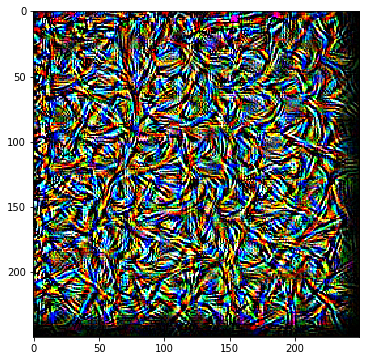

In [4]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    regularization = [WeightDecay(1e-3)],
    iter_n=12
).visualize())

## 1.3 Blur Filter
Performs simple blurring after each step. Has the issue that edges are not preserved.

100%|██████████| 12/12 [00:16<00:00,  1.26s/it]


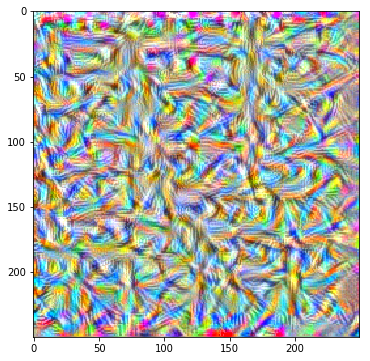

In [5]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform = BlurTransform()
).visualize())

## 1.4 Bilateral Filter
Like blur, but preserves edges.

100%|██████████| 12/12 [00:14<00:00,  1.09s/it]


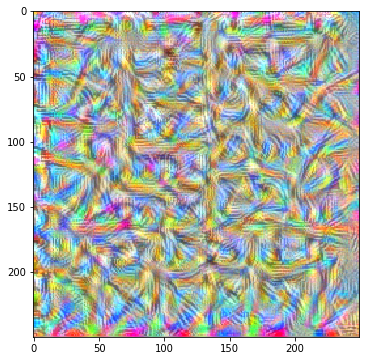

In [6]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=BilateralTransform()
).visualize())

## 1.5 Random robustness transformations
Apply random translation, rotation, and scaling after each iteration

100%|██████████| 12/12 [00:17<00:00,  1.14s/it]


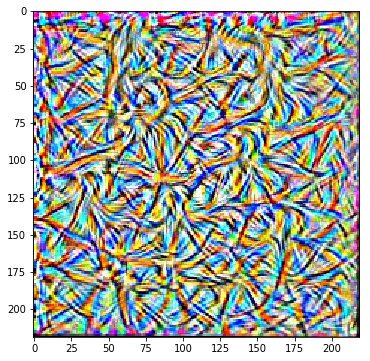

In [7]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=RandomTransform()
).visualize())

## 1.6 Resizing transform
After each iteration, scale the image up. This has the advantage that low-frequency patterns can be picked up better.

100%|██████████| 12/12 [00:10<00:00,  1.41s/it]


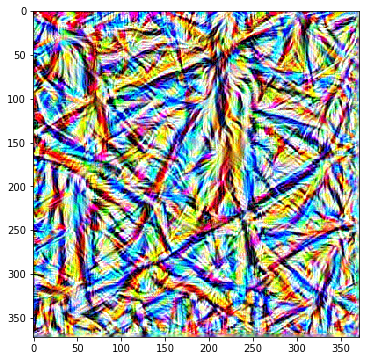

In [8]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=ResizeTransform(),
    init_size=50
).visualize())

## 1.7 Total Variation Regularizer
Add total variation to the loss, which punishes difference in adjacent pixels.

100%|██████████| 12/12 [00:18<00:00,  1.34s/it]


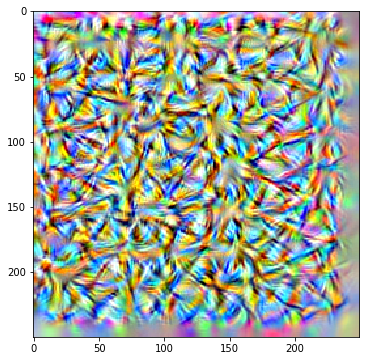

In [9]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    regularization=[TVRegularization(5e2)]
).visualize())

# 2. Combining regularizers
 - weight decay to gray out irrelevant parts
 - blur (or biliteral filter) for penalizing high-frequency noise
 - resizing to capture low-frequency patterns
 - random transformations to get robust image
 - total variation to get more natural looking image

100%|██████████| 12/12 [00:10<00:00,  1.50s/it]


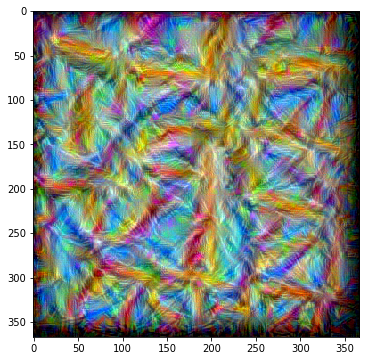

In [10]:
show(PixelActivation(
    alexnet.features[:9],
    SplitSelector(ChannelSplit(), [1]),
    transform=RandomTransform()+BlurTransform()+ResizeTransform(),
    regularization=[TVRegularization(), WeightDecay(3e-4)],
    init_size=50
).visualize())

# 3. Spatial and Individual Splits
## 3.1 Spatial
Note how some parts of the image do not have any influence on the gradient, since the convolutions have not yet progressed as far.

100%|██████████| 12/12 [00:11<00:00,  1.22it/s]


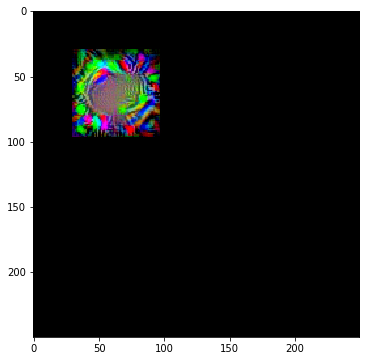

In [11]:
show(PixelActivation(
    alexnet.features[:6],
    SplitSelector(SpatialSplit(), [3, 3]),
    transform=BlurTransform(),
    regularization=[WeightDecay(1e-3)]
).visualize())

# 3.2 Individual Neurons

100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


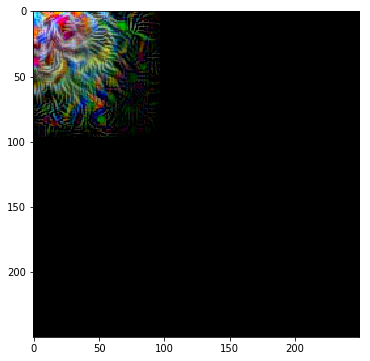

In [14]:
show(PixelActivation(
    alexnet.features[:11],
    SplitSelector(NeuronSplit(), [0, 0, 0]),
    transform=BlurTransform(),
    regularization=[WeightDecay(1e-2)]
).visualize())

# 4. Class visualization
Try to visualize class 783 (Screw)

TODO experiment (using a GPU) and add result here